# Series temporales



En primer lugar vamos a ver como podemos resolver el problema de predicción de series temporales haciendo uso de redes neuronales recurrentes RNN. 

Empezaremos por evaluar las RNN simples y, a continuación, trataremos de resolver el mismo problema con LSTM.

Para ello, vamos a hacer uso de una base de datos que pemite predecir los valores de calidad del aiere. Cada serie temporal representa los valores de distintos indicadores de calidad del aire entre 2013 y 2019.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from datetime import datetime

from pandas import Series
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras 

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Leemos la base de datos
path = '/content/drive/MyDrive/datoscsv/'
df = pd.read_csv(path + 'airWeather_2013-2019_v3.csv', sep=';', index_col='FECHA', parse_dates=['FECHA'])
df.index.name = 'index'
df

,COD_ESTACION,NOM_ESTACION,SO2,NO,NO2,NOx,O3,PM10,PM2.5,lluvias,Temp,VelocVent
index,,,,,,,,,,,,
2013-01-01,46250043,VALÈNCIA VIVERS,1.0,5.0,30.0,39.0,27.0,6.0,5.0,0.0,13.70,0.6
2013-01-02,46250043,VALÈNCIA VIVERS,6.0,83.0,85.0,211.0,16.0,18.0,6.0,0.0,11.40,0.6
2013-01-03,46250043,VALÈNCIA VIVERS,3.0,32.0,69.0,117.0,16.0,18.0,12.0,NaN,NaN,NaN
2013-01-04,46250043,VALÈNCIA VIVERS,4.0,50.0,79.0,156.0,12.0,19.0,13.0,NaN,NaN,NaN
2013-01-05,46250043,VALÈNCIA VIVERS,3.0,47.0,75.0,147.0,9.0,22.0,16.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,46250048,VALÈNCIA MOLÍ DEL SOL,3.0,21.0,26.0,58.0,16.0,36.0,33.0,0.0,13.55,7.0
2019-12-28,46250048,VALÈNCIA MOLÍ DEL SOL,3.0,15.0,23.0,46.0,17.0,40.0,38.0,0.0,10.55,9.0
2019-12-29,46250048,VALÈNCIA MOLÍ DEL SOL,3.0,6.0,18.0,27.0,27.0,41.0,40.0,0.0,11.75,8.0


In [4]:
# seleccionar solo una estación para pruebas
df = df[df['COD_ESTACION']==46250048]

# Dejar solo los datos más correlacionados para pruebas
df = df[['NO',	'NO2',	'NOx',	'O3',	'Temp']]


# eliminar filas  que tengan algun valor nulo
df = df.dropna()
df.isnull().sum()

# Reestablecemos índices filas (sino se mantienen índices originales)
# df = df.reset_index().drop(['index'], axis=1)


NO      0
NO2     0
NOx     0
O3      0
Temp    0
dtype: int64

## Preparación de datos

In [5]:
df

,NO,NO2,NOx,O3,Temp
index,,,,,
2013-01-01,6.0,38.0,48.0,38.0,13.70
2013-01-02,72.0,40.0,151.0,19.0,11.40
2013-05-03,10.0,44.0,59.0,44.0,16.00
2013-05-04,11.0,44.0,60.0,47.0,16.50
2013-05-05,13.0,19.0,38.0,52.0,17.10
...,...,...,...,...,...
2019-12-27,21.0,26.0,58.0,16.0,13.55
2019-12-28,15.0,23.0,46.0,17.0,10.55
2019-12-29,6.0,18.0,27.0,27.0,11.75


In [6]:
df = df.transpose()
df

index,2013-01-01,2013-01-02,2013-05-03,2013-05-04,2013-05-05,2013-05-06,2013-05-07,2013-05-08,2013-05-09,2013-05-10,...,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31
NO,6.0,72.0,10.0,11.0,13.0,15.0,15.0,23.00,22.0,16.00,...,2.0,4.00,15.0,14.00,32.00,21.00,15.00,6.00,18.0,12.0
NO2,38.0,40.0,44.0,44.0,19.0,34.0,41.0,48.00,32.0,35.00,...,1.0,15.00,21.0,18.00,27.00,26.00,23.00,18.00,23.0,21.0
NOx,48.0,151.0,59.0,60.0,38.0,58.0,65.0,83.00,65.0,60.00,...,4.0,20.00,44.0,40.00,76.00,58.00,46.00,27.00,50.0,39.0
O3,38.0,19.0,44.0,47.0,52.0,52.0,41.0,34.00,51.0,39.00,...,61.0,42.00,22.0,19.00,13.00,16.00,17.00,27.00,21.0,17.0
Temp,13.7,11.4,16.0,16.5,17.1,18.5,24.1,24.45,20.1,19.45,...,18.5,17.15,17.8,15.95,16.75,13.55,10.55,11.75,9.9,8.7


In [7]:
# Reestablecemos índices filas (sino se mantienen como estaba)
df = df.reset_index().drop(['index'], axis=1)
df

index,2013-01-01,2013-01-02,2013-05-03,2013-05-04,2013-05-05,2013-05-06,2013-05-07,2013-05-08,2013-05-09,2013-05-10,...,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31
0,6.0,72.0,10.0,11.0,13.0,15.0,15.0,23.00,22.0,16.00,...,2.0,4.00,15.0,14.00,32.00,21.00,15.00,6.00,18.0,12.0
1,38.0,40.0,44.0,44.0,19.0,34.0,41.0,48.00,32.0,35.00,...,1.0,15.00,21.0,18.00,27.00,26.00,23.00,18.00,23.0,21.0
2,48.0,151.0,59.0,60.0,38.0,58.0,65.0,83.00,65.0,60.00,...,4.0,20.00,44.0,40.00,76.00,58.00,46.00,27.00,50.0,39.0
3,38.0,19.0,44.0,47.0,52.0,52.0,41.0,34.00,51.0,39.00,...,61.0,42.00,22.0,19.00,13.00,16.00,17.00,27.00,21.0,17.0
4,13.7,11.4,16.0,16.5,17.1,18.5,24.1,24.45,20.1,19.45,...,18.5,17.15,17.8,15.95,16.75,13.55,10.55,11.75,9.9,8.7


### Eliminación de NaN

Vemos que las diferentes columnas contienen los valores de un día concreto. Hay registros diarios desde el 01.01.2013 al 31.12.2019

In [8]:
df.columns

Index([2013-01-01 00:00:00, 2013-01-02 00:00:00, 2013-05-03 00:00:00,
       2013-05-04 00:00:00, 2013-05-05 00:00:00, 2013-05-06 00:00:00,
       2013-05-07 00:00:00, 2013-05-08 00:00:00, 2013-05-09 00:00:00,
       2013-05-10 00:00:00,
       ...
       2019-12-22 00:00:00, 2019-12-23 00:00:00, 2019-12-24 00:00:00,
       2019-12-25 00:00:00, 2019-12-26 00:00:00, 2019-12-27 00:00:00,
       2019-12-28 00:00:00, 2019-12-29 00:00:00, 2019-12-30 00:00:00,
       2019-12-31 00:00:00],
      dtype='object', name='index', length=2331)

De la información del DataFrame vemos que para algunas páginas tenemos registros desconocidos (NaN), estos registros vamos a eliminarlos.

In [9]:
# Eliminamos registros en los que tenemos valores nulos
new_df = df.dropna()

In [10]:
new_df.shape

(5, 2331)

In [11]:
new_df

index,2013-01-01,2013-01-02,2013-05-03,2013-05-04,2013-05-05,2013-05-06,2013-05-07,2013-05-08,2013-05-09,2013-05-10,...,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31
0,6.0,72.0,10.0,11.0,13.0,15.0,15.0,23.00,22.0,16.00,...,2.0,4.00,15.0,14.00,32.00,21.00,15.00,6.00,18.0,12.0
1,38.0,40.0,44.0,44.0,19.0,34.0,41.0,48.00,32.0,35.00,...,1.0,15.00,21.0,18.00,27.00,26.00,23.00,18.00,23.0,21.0
2,48.0,151.0,59.0,60.0,38.0,58.0,65.0,83.00,65.0,60.00,...,4.0,20.00,44.0,40.00,76.00,58.00,46.00,27.00,50.0,39.0
3,38.0,19.0,44.0,47.0,52.0,52.0,41.0,34.00,51.0,39.00,...,61.0,42.00,22.0,19.00,13.00,16.00,17.00,27.00,21.0,17.0
4,13.7,11.4,16.0,16.5,17.1,18.5,24.1,24.45,20.1,19.45,...,18.5,17.15,17.8,15.95,16.75,13.55,10.55,11.75,9.9,8.7


In [12]:
# Reestablecemos índices filas (sino se mantienen índices originales)
#new_df = new_df.reset_index().drop(['index'], axis=1)
#new_df

### Reorganización de columnas

In [13]:
# Hacemos una copia del DataFrame ya que le vamos a aplicar más transformaciones (no se usa?)
new_df_copy = new_df.copy()

In [14]:
# Eliminamos la columna Page ya que no es relevante para el modelo
# new_df = new_df.drop(['Page'], axis=1)

In [15]:
# Visualizamos 10 primeros registros
new_df.head(10)

index,2013-01-01,2013-01-02,2013-05-03,2013-05-04,2013-05-05,2013-05-06,2013-05-07,2013-05-08,2013-05-09,2013-05-10,...,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31
0,6.0,72.0,10.0,11.0,13.0,15.0,15.0,23.00,22.0,16.00,...,2.0,4.00,15.0,14.00,32.00,21.00,15.00,6.00,18.0,12.0
1,38.0,40.0,44.0,44.0,19.0,34.0,41.0,48.00,32.0,35.00,...,1.0,15.00,21.0,18.00,27.00,26.00,23.00,18.00,23.0,21.0
2,48.0,151.0,59.0,60.0,38.0,58.0,65.0,83.00,65.0,60.00,...,4.0,20.00,44.0,40.00,76.00,58.00,46.00,27.00,50.0,39.0
3,38.0,19.0,44.0,47.0,52.0,52.0,41.0,34.00,51.0,39.00,...,61.0,42.00,22.0,19.00,13.00,16.00,17.00,27.00,21.0,17.0
4,13.7,11.4,16.0,16.5,17.1,18.5,24.1,24.45,20.1,19.45,...,18.5,17.15,17.8,15.95,16.75,13.55,10.55,11.75,9.9,8.7


In [16]:
# Vamos a cambiar los nombre de las columnas por instantes temporales (0, 1, ...) para facilitar su posterior uso
new_df.columns = [ i for i,x in enumerate(new_df.columns)]
    
new_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2321,2322,2323,2324,2325,2326,2327,2328,2329,2330
0,6.0,72.0,10.0,11.0,13.0,15.0,15.0,23.00,22.0,16.00,...,2.0,4.00,15.0,14.00,32.00,21.00,15.00,6.00,18.0,12.0
1,38.0,40.0,44.0,44.0,19.0,34.0,41.0,48.00,32.0,35.00,...,1.0,15.00,21.0,18.00,27.00,26.00,23.00,18.00,23.0,21.0
2,48.0,151.0,59.0,60.0,38.0,58.0,65.0,83.00,65.0,60.00,...,4.0,20.00,44.0,40.00,76.00,58.00,46.00,27.00,50.0,39.0
3,38.0,19.0,44.0,47.0,52.0,52.0,41.0,34.00,51.0,39.00,...,61.0,42.00,22.0,19.00,13.00,16.00,17.00,27.00,21.0,17.0
4,13.7,11.4,16.0,16.5,17.1,18.5,24.1,24.45,20.1,19.45,...,18.5,17.15,17.8,15.95,16.75,13.55,10.55,11.75,9.9,8.7


In [17]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 0 to 4
Columns: 2331 entries, 0 to 2330
dtypes: float64(2331)
memory usage: 91.1 KB


### Preparación de datos para análisis de series temporales

Para entrenar el modelo tenemos que definir el número de instantes temporales que vamos a introducir al modelo como entrada.
Así la RNN tiene que recibir una matriz 3D con las siguientes dimensiones: 

[tamaño lote, nº de instantes temporales, nº de características en un instante temporal].

[117273, 160, 1]

Por lo tanto, vamos a crear dicha matriz:

In [18]:
num_steps = 160 # Número de instantes temporales

master_series = []

# Recorremos todos los registros
for i in range(len(new_df)):
    
    ### No empleamos registros que tengan todos sus valores a 0 (=desconocido)
    if (max(new_df.iloc[i, 0:num_steps]) == 0 ):
        continue
      
    # De cada serie temporal seleccionamos los primeros 160 instantes temporales
    myseries = np.array(new_df.iloc[i][0:num_steps])
    master_series.append(myseries)
    
master_series = np.array(master_series)

# añadimos una dimensión porque sólo usamos una variable: número de visitas en un día
master_series = master_series[..., np.newaxis].astype(np.float32)

('Tamaño base de datos: ', master_series.shape)

('Tamaño base de datos: ', (5, 160, 1))

Vemos que hemos perdido 3 registros tras eliminar aquellos con todos los registros a 0 (hemos pasado de 117276 a 117273)

### Eliminación de Outliers

Ahora vamos a ver si tenemos valores atípicos (outliers) y, en tal caso, eliminarlos de la base de datos.

Para ello vamos a calcular los percentiles 1, 5, 95, 99, así como los valores mínimo y máximo de la base de datos. 

In [19]:
# Convertimos matriz a vector
master_series_values = master_series.reshape(-1,1)

# Percentiles
print(np.percentile(master_series_values, [1, 5, 95, 99]))
# Mínimo
print(master_series_values.min())
# Máximo
print(master_series_values.max())

[ 1.  3. 59. 73.]
0.0
151.0


Del análisis anterior se puede observar que hay valores muy altos en nuestra base de datos. Esto se observa porque el percentil 99 tiene un valor de 9883, sin embargo, el valor máximo es muy superior, por lo tanto, estos registros por encima del percentil 99 se pueden considerar valores atípicos.

De este modo, vamos a dejar únicamente los registros con valores inferiores o iguales al percentil 99.

In [20]:
"""perc_99 = np.percentile(master_series_values,99)

### Mantenemos únicamente los registros con valores inferiores al percentil 99

master_wo_outliers = [master_series[i] for i in range(0, master_series.shape[0]) \
                      if (max(master_series[i,:]) <= perc_99)]

### Convertimos lista a vector
master_wo_outliers = np.array(master_wo_outliers)

print('Tamaño matriz antes de eliminar valores atípicos:', master_series.shape)
print('Tamaño matriz tras eliminar valores atípicos:', master_wo_outliers.shape)

### Calculamos percentil 99 y valor máximo del nuevo dataset
print(np.percentile(master_wo_outliers, 99))
print(master_wo_outliers.max())"""

master_wo_outliers = master_series

Podemos observar que ya no tenemos valores atípicos (ya no hay tanta diferencia entre el percentil 99 y el valor máximo).

En este paso hemos eliminado 15053 registros con valores atípicos.

In [21]:
# Creamos copia bases de datos antes y después de eliminar los valores atípicos (no se usan?)
master_series_orig = master_series.copy()
master_wo_outliers_copy = master_wo_outliers.copy()

In [22]:
master_series = master_wo_outliers
master_series.shape

(5, 160, 1)

### Valores logarítmicos

In [23]:
# Fijamos semilla aleatoria para tener todos los mismos resultados
np.random.seed(42)
# Mezclamos el dataset
np.random.shuffle(master_series)

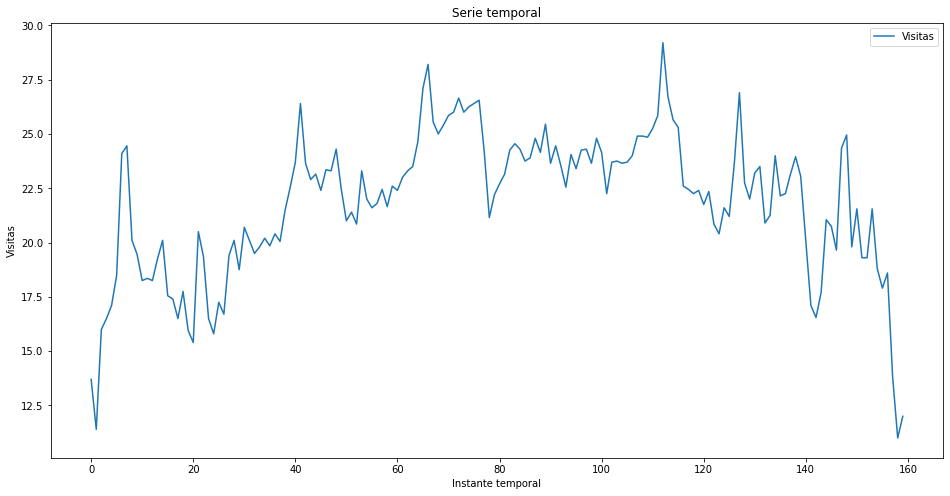

In [24]:
# Mostramos la serie temporal de una muestra dada

plt.figure(figsize=(16,8))
sample = 1

plt.plot(master_series[sample,:], label = 'Visitas')
plt.title('Serie temporal')
plt.xlabel("Instante temporal")
plt.ylabel("Visitas")
plt.legend(loc = 'best')

Se observa que el rango de la serie temporal es muy grande. Para disminuir este rango vamos a escalar los registros mediante una transformación logarítmica.

In [25]:
log_master_series = []

for i in range(master_series.shape[0]):
    
    # Hay muchos instantes con valor 0 en la base de datos. Para tratar bien con estos vamos a sumarle 1 a todos los registros
    # Esto lo deberemos de tener en cuenta a posteriori, en el momento de inferencia, al deshacer la transformación aplicada
    temp_series = np.array(np.log(master_series[i][0:] + 1))
    log_master_series.append(temp_series)
    
log_master_series = np.array(log_master_series) 

# Vemos algunos registros
print(log_master_series[0,:10])

[[3.6635616]
 [3.713572 ]
 [3.8066626]
 [3.8066626]
 [2.9957323]
 [3.5553482]
 [3.7376697]
 [3.8918202]
 [3.4965076]
 [3.583519 ]]


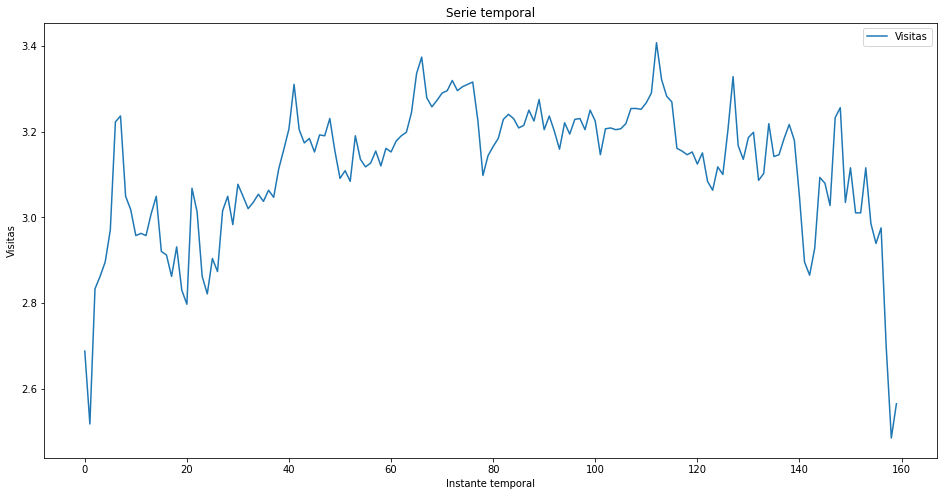

In [26]:
# Mostramos el mismo registro que antes tras aplicar transformación logarítmica
plt.figure(figsize=(16,8))
sample = 1

plt.plot(log_master_series[sample,:], label = 'Visitas')
plt.title('Serie temporal')
plt.xlabel("Instante temporal")
plt.ylabel("Visitas")
plt.legend(loc = 'best')

Vemos que el rango se ha reducido considerablemente.

### Train, validation, test

En este punto vamos a crear las bases de datos de entrenamiento, validación y test. Para todas ellas vamos a emplear 150 registros para entrenar y vamos a tratar de predecir un instante temporal, es decir, el instante temporal 151.

Para ello vamos a emplear 70.000 registros para entrenar, 20.000 para validar y 10.000 para testear.

In [27]:
log_master_series.shape

(5, 160, 1)

In [28]:
np.random.seed(42)

# Número instante temporales "conocidos"
n_steps = 150

# Instante temporal a predecir
predicted_day = n_steps + 1

# Entrenamiento
X_train, y_train = log_master_series[:70000, :n_steps], log_master_series[:70000, n_steps]
# Validación
X_valid, y_valid = log_master_series[70000:90000, :n_steps], log_master_series[70000:90000, n_steps]
# Test
X_test, y_test = log_master_series[90000:100000, :n_steps], log_master_series[90000:100000, n_steps]

In [29]:
print('Datos entrada entrenamiento:', X_train.shape)
print('Datos salida entrenamiento:', y_train.shape)

print('Datos entrada validación:', X_valid.shape)
print('Datos salida validación:', y_valid.shape)

print('Datos entrada test:', X_test.shape)
print('Datos salida test:', y_test.shape)

Datos entrada entrenamiento: (5, 150, 1)
Datos salida entrenamiento: (5, 1)
Datos entrada validación: (0, 150, 1)
Datos salida validación: (0, 1)
Datos entrada test: (0, 150, 1)
Datos salida test: (0, 1)


Vamos a tratar de entender las dimensiones de las matrices que hemos generado.

X_train:
* 70.000 - Número de registros.
* 150 - Número de instantes temporales empleados para entrenar (instantes temporales conocidos).
* 1 - Número de valores (sólo vamos a emplear una variable, esto es, el número de visitas en un día).

y_train:

* 70000 - Número de registros.
* 1 - Número de instantes temporales a predecir.

Finalmente, vamos a normalizar los registros para que se encuentren en un rango entre 0-1. 

Para ello vamos a hacer uso del método MinMaxScaler de scikit-learn y vamos a ajustarlo con los datos de entrenamiento. Una vez ajustado, lo emplearemos para normalizar las 3 bases de datos (entrenamiento, validación y test).

In [30]:
X_train.reshape(-1, 1).shape

(750, 1)

In [31]:
# Normalización entre 0-1

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Ajustamos normalizador con los datos de entrenamiento y los transformamos
X_train_values = X_train.reshape(-1, 1) # Convertimos a vector
X_train_normalized = scaler.fit_transform(X_train_values)

# Transformamos datos entrenamiento
y_train_normalized = scaler.transform(y_train)


# Transformamos datos validación
X_valid_values = X_valid.reshape(-1, 1)
X_valid_normalized = scaler.transform(X_valid_values)
y_valid_normalized = scaler.transform(y_valid)


# Transformamos datos test
X_test_values = X_test.reshape(-1, 1)
X_test_normalized = scaler.transform(X_test_values)
y_test_normalized = scaler.transform(y_test)


# Redimensionamos las matrices para que vuelvan al tamaño deseado (3D)
X_train = X_train_normalized.reshape(X_train.shape[0] , X_train.shape[1] , X_train.shape[2])
X_valid = X_valid_normalized.reshape(X_valid.shape[0] ,X_valid.shape[1] , X_valid.shape[2])
X_test = X_test_normalized.reshape(X_test.shape[0] ,X_test.shape[1] , X_test.shape[2])

y_train = y_train_normalized.reshape(y_train.shape[0], y_train.shape[1] )
y_valid = y_valid_normalized.reshape(y_valid.shape[0], y_valid.shape[1] )
y_test =  y_test_normalized.reshape(y_test.shape[0], y_test.shape[1] )

# Comprobamos dimensiones matrices
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

ValueError: ignored

In [ ]:
print('Rango datos entrada entrenamiento:', X_train.min(), '-', X_train.max())
print('Rango datos salida entrenamiento:', y_train.min(), '-', y_train.max())

print('Rango datos entrada validación:', X_valid.min(), '-', X_valid.max())
print('Rango datos salida validación:', y_valid.min(), '-', y_valid.max())

print('Rango datos entrada test:', X_test.min(), '-', X_test.max())
print('Rango datos salida test:', y_test.min(), '-', y_test.max())

In [ ]:
# Vamos a crear un método para deshacer las transformaciones que hemos aplicado para que se encuentren en el rango original

def reverse_transform(arr):
    
    arr = arr.reshape(-1,1)
    
    # Deshacemos escalado MinMax
    arr_inv_normal = scaler.inverse_transform(arr)
    
    # Deshacemos transformación logarítmica y restamos 1 (del que hemos sumando antes)
    arr_reverse = np.exp(arr_inv_normal ) - 1
    return (arr_reverse)

### Visualización

In [ ]:
# Método para mostrar serie temporal 
def plot_series(series, y=None, y_pred=None, lag=n_steps, x_label="Instante temporal", y_label="Valor"):
    
    plt.figure(figsize=(14,7))
    plt.plot(np.arange(n_steps-lag, n_steps), series, ".-")
    
    if y is not None:
        # Salida real
        plt.plot(n_steps, y, "bX", markersize=10)
        
    if y_pred is not None:
        # Salida predicha
        plt.plot(n_steps, y_pred, "ro")
        
    plt.grid(True)
    
    if x_label:
        plt.xlabel(x_label, fontsize=12)
    if y_label:
        plt.ylabel(y_label, fontsize=12, rotation=90)
    
    
    plt.axis([n_steps-lag, n_steps+1 , 0, 1])
    plt.xticks(np.arange(n_steps-lag, n_steps+1, 1))
    plt.yticks(np.arange(0, 1, 0.1))



In [ ]:
# Mostramos 20 últimos instantes temporales de 3 registros de validación
for i in range(3):
    plot_series(X_valid[i, n_steps-20 : , 0], y_valid[i, 0],
                lag=20, x_label="ültimos 20 instantes temporales", y_label=("Valor"))
    
plt.show()

## RNN Simple

En primer lugar vamos a implementar una arquitectura sencilla con una RNN simple.

In [ ]:
# Fijamos semillas numpy y Tensorflow para obtener los mismos resultados (para experimentos reales esto no usarlo)
np.random.seed(42)
tf.random.set_seed(42)

# Definimos arquitectura
simp_rnn_model = keras.models.Sequential([
        keras.layers.SimpleRNN(1, input_shape=[None, 1]) #### RNN con una única neurona
])

simp_rnn_model.summary()

# Tasa de aprendizeja
optimizer = keras.optimizers.Adam(lr=0.0001)

# Compilamos. Función de coste MSE (regresión)
simp_rnn_model.compile(loss="mse", optimizer=optimizer)

# Paramos entrenamiento si no hay mejora en validación en las últimas 5 épocas
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, verbose=1)

NOTA: El entrenamiento es largo (3.5 min por época aprox.) para primeros experimentos podéis probar dividiendo la base de datos de entrenamiento a la mitad.

In [ ]:
# Entrenamiento
history_srnn = simp_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping])

In [ ]:
simp_rnn_model.save('srnn.h5')
history_df = pd.DataFrame(simp_rnn_model.history.history)
history_df.to_csv('srnn.history.csv')

In [ ]:
# Visualizamos curvas de aprendizaje
import matplotlib
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Pérdidas entrenamiento")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Pérdidas validación")
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Época")
    plt.ylabel("Pérdidas (MSE)")
    plt.grid(True)

In [ ]:
plot_learning_curves(history_srnn.history["loss"][1:], history_srnn.history["val_loss"][1:])
plt.show()

In [ ]:
# Evaluamos modelos sobre el set de test
simp_rnn_mse = simp_rnn_model.evaluate(X_test, y_test, verbose=0)
print('MSE test RNN simple:', simp_rnn_mse)

In [ ]:
# Método para mostrar predicción de un instante temporal

def plot_single_prediction(series, y, y_pred, sample, lag = n_steps, x_label = "Instante temporal", y_label = "Valor"):

    plt.figure(figsize=(16,8))

    plt.plot(np.arange(n_steps - lag, n_steps), series, ".-", label = 'Últimas ' + str(lag) + ' visitas')
    plt.plot(n_steps, y, "ro", label = 'Real = ' + str(y[0,0]))
    plt.plot(n_steps, y_pred, "gx",  label = 'Predicción = '+ str(y_pred[0,0]))
    plt.xticks(np.arange(n_steps - lag, n_steps + 1, 1))
    
    plt.title('Número de visitas predichas para muestra ' + str(sample) + \
              ', en el día ' + str(n_steps + 1))

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc = 'best')

In [ ]:
y_pred_srnn = simp_rnn_model.predict(X_test)

# Visualizamos predicción de un caso de test (registro 55)
sample=55
lag=20

plot_single_prediction(reverse_transform(X_test[sample, n_steps - lag : , 0]), \
                       reverse_transform(y_test[sample]), reverse_transform(y_pred_srnn[sample]), \
                       sample = sample, lag = lag, x_label = "Día", y_label = "Instante temporal")

Vemos que hay error en la predicción con el modelo anterior. Vamos a construir un RNN más profunda y más unidades.

## RNN Profunda

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Definimos la arquitectura
d_rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(rate=0.2),   ### Esta capa de Dropout hace que las pérdidas en validación no fluctúen mucho
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)      
])

# Tasa de aprendizaje
optimizer = keras.optimizers.Adam(lr=0.0001)
# Compilamos
d_rnn_model.compile(loss="mse", optimizer=optimizer)

d_rnn_model.summary()

#Paramos entrenamiento si no hay mejora en validación en las últimas 5 épocas
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# Guardamos pesos modelo que genere las menores pérdidas en validación
mc = keras.callbacks.ModelCheckpoint('best_model_drnn.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# 8 minutos por época

# Entrenamos RCNN más profunda
history_drnn = d_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping, mc])

In [ ]:
d_rnn_model.save('drnn.h5')

In [ ]:
# Representamos curvas pérdidas entrenamiento y validación
plot_learning_curves(history_drnn.history["loss"][1:], history_drnn.history["val_loss"][1:])
plt.show()

In [ ]:
# Cargamos los pesos del modelo que mejores pérdidas en validación nos ha dado
d_rnn_model = keras.models.load_model('best_model_drnn.h5')

In [ ]:
# Evaluamos sobre conjunto de test
deep_rnn_mse = d_rnn_model.evaluate(X_test, y_test, verbose=0)

print('MSE RNN simple: ', simp_rnn_mse)
print('MSE RNN profunda: ', deep_rnn_mse)

In [ ]:
y_pred_drnn = d_rnn_model.predict(X_test)

In [ ]:
plt.figure(figsize=(16,8))

num_samples = 40

# Comparamos predicciones reales de 40 registros frente a RNN simple y profunda
plt.plot(reverse_transform(y_test[0:num_samples]), '.-', label = 'Visitas reales')
plt.plot(reverse_transform(y_pred_srnn[0:num_samples]), 'o-', label = 'Predicciones RNN simple')
plt.plot(reverse_transform(y_pred_drnn[0:num_samples]), 'X-', label = 'Predicciones RNN profunda')
plt.title('Visitas predichas para ' + str(num_samples) + ' muestras, en el día ' + str(predicted_day))
plt.xlabel("Muestra serie temporal")
plt.ylabel("Visitas")
plt.legend(loc = 'best')

In [ ]:
# Visualizamos predicción muestra analizada set de test
sample=55
lag=20

plot_single_prediction(reverse_transform(X_test[sample, n_steps - lag : , 0]), \
                       reverse_transform(y_test[sample]), reverse_transform(y_pred_drnn[sample]), \
                       sample = sample, lag = lag, x_label = "Días", y_label = "Visitas")

En comparación con el modelo simple podemos ver menor error en la preducción (valor predicho más cercano al real).

## LSTM

La siguiente prueba que vamos a realizar es emplear bloques LSTM en lugar de RNN.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Arquitectura
lstm_model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]), # Poner return_seq en las capas LSTM intermedias para pasar los valores h a la capa siguiente
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)  
])

# Tasa de aprendizaje
optimizer = keras.optimizers.Adam(lr=0.0005)
# Compilamos

lstm_model.compile(loss="mse", optimizer=optimizer)
lstm_model.summary()

#Paramos entrenamiento si no hay mejora en validación en las últimas 5 épocas
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# Guardamos pesos modelo que genere las menores pérdidas en validación
mc = keras.callbacks.ModelCheckpoint('best_model_lstm.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
history_lstm = lstm_model.fit(X_train, y_train, epochs=80, batch_size=32,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping, mc])

In [ ]:
lstm_model.save('lstm.h5')

In [ ]:
# Cargamos pesos de la época en la que se han obtenido menores pérdidas en validación
lstm_model = keras.models.load_model('best_model_lstm.h5')

In [ ]:
# Mostramos pérdidas entrenamiento y validación
plot_learning_curves(history_lstm.history["loss"][1:], history_lstm.history["val_loss"][1:])
plt.show()

In [ ]:
# Calculamos y comparamos MSE test
lstm_mse = lstm_model.evaluate(X_test, y_test, verbose=0)
print('MSE RCNN simple: ', simp_rnn_mse)
print('MSE RCNN profunda: ', deep_rnn_mse)
print('MSE LSTM: ', lstm_mse)

In [ ]:
y_pred_lstm = lstm_model.predict(X_test)

In [ ]:
plt.figure(figsize=(16,8))

num_samples = 40

# Comparamos predicciones reales de 40 registros frente a RNN simple y profunda
plt.plot(reverse_transform(y_test[0:num_samples]), '.-', label = 'Visitas reales')
plt.plot(reverse_transform(y_pred_srnn[0:num_samples]), 'o-', label = 'Predicciones RNN simple')
plt.plot(reverse_transform(y_pred_drnn[0:num_samples]), 'X-', label = 'Predicciones RNN profunda')
plt.plot(reverse_transform(y_pred_lstm[0:num_samples]), 'x-', label = 'Predicciones LSTM')
plt.title('Visitas predichas para ' + str(num_samples) + ' muestras, en el día ' + str(predicted_day))
plt.xlabel("Muestra serie temporal")
plt.ylabel("Visitas")
plt.legend(loc = 'best')

In [ ]:
sample=55
lag=20

plot_single_prediction(reverse_transform(X_test[sample, n_steps - lag : , 0]), \
                       reverse_transform(y_test[sample]), reverse_transform(y_pred_lstm[sample]), \
                       sample = sample, lag = lag, x_label = "Días", y_label = "Visitas")

### Predicción de una secuencia

Ahora vamos a tratar de predecir más de un día, concretamente 3.



In [ ]:
np.random.seed(42)

# Número instante temporales "conocidos"
n_steps = 150

# Número de días a predecir
num_days_predicted = 3

# Vamos a emplear los datos tras la trasformación logarítmica y partición (antes de escalar entre 0 y 1)
# Vamos a añadir dos registros más a las variables salida.

series = log_master_series[:, : n_steps + num_days_predicted, :]
series.shape

y_train_mult = series[:70000, -num_days_predicted:, 0]
y_valid_mult = series[70000:90000, -num_days_predicted:, 0]
y_test_mult =  series[90000:100000, -num_days_predicted:, 0]

print('Tamaño datos salida entrenamiento:', y_train_mult.shape)
print('Tamaño datos salida validación:', y_valid_mult.shape)
print('Tamaño datos salida test:', y_test_mult.shape)

In [ ]:
# Escalamos las matrices generadas entre 0 y 1 
# Las matrices con los datos de entrada a la red van a ser los mismos.

# Entrenamiento
y_train_normalized = scaler.transform(y_train_mult.reshape(-1,1))
y_train_mult = y_train_normalized.reshape(y_train_mult.shape[0], y_train_mult.shape[1])

# Validación
y_valid_normalized = scaler.transform(y_valid_mult.reshape(-1,1))
y_valid_mult = y_valid_normalized.reshape(y_valid_mult.shape[0], y_valid_mult.shape[1])

# Test
y_test_normalized = scaler.transform(y_test_mult.reshape(-1,1))
y_test_mult = y_test_normalized.reshape(y_test_mult.shape[0], y_test_mult.shape[1])

print('Rango datos entrada entrenamiento:', X_train.min(), '-', X_train.max())
print('Rango datos salida entrenamiento:', y_train_mult.min(), '-', y_train_mult.max())

print('Rango datos entrada validación:', X_valid.min(), '-', X_valid.max())
print('Rango datos salida validación:', y_valid_mult.min(), '-', y_valid_mult.max())

print('Rango datos entrada test:', X_test.min(), '-', X_test.max())
print('Rango datos salida test:', y_test_mult.min(), '-', y_test_mult.max())

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Arquitectura con bloques LSTM
lstm_mult_model1 = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.Dropout(rate=0.2),
    keras.layers.LSTM(20),
    keras.layers.Dense(num_days_predicted)
])

# Tasa de aprendizaje
optimizer = keras.optimizers.Adam(lr=0.0005)
# Compilamos
lstm_mult_model1.compile(loss="mse", optimizer = optimizer)

lstm_mult_model1.summary()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = keras.callbacks.ModelCheckpoint('best_model_mult_lstm.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)


In [ ]:
history_mult_lstm1 = lstm_mult_model1.fit(X_train, y_train_mult, epochs=80, batch_size=32,
                    validation_data=(X_valid, y_valid_mult), callbacks=[early_stopping, mc])

In [ ]:
lstm_mult_model1.save('lstm_mult.h5')

In [ ]:
# Cargamos pesos de la época en la que se han obtenido las menores pérdidas en validación
lstm_mult_model1 = keras.models.load_model('best_model_mult_lstm.h5')

In [ ]:
# Mostramos pérdidas en entrenamiento y validación
plot_learning_curves(history_mult_lstm1.history["loss"][1:], history_mult_lstm1.history["val_loss"][1:])
plt.show()

In [ ]:
lstm_mult_model1.evaluate(X_test, y_test_mult)

In [ ]:
y_pred_mult_lstm = lstm_mult_model1.predict(X_test)

In [ ]:
sample_tested = 200

plt.figure(figsize=(8,4))

plt.plot(reverse_transform(y_test_mult[sample_tested]),  ".-", label = 'Visitas reales')
plt.plot(reverse_transform(y_pred_mult_lstm[sample_tested]),  ".-", label = 'Predicciones LSTM')

plt.xlabel("Días")
plt.ylabel("Visitas")
plt.legend(loc = 'best')

In [ ]:
# Método para mostrar predicción de múltiples instantes

def plot_multiple_predictions(series, y, y_pred, sample, lag = n_steps, num_days_predicted =3, \
                              x_label = "Instantes temporales", y_label = "Valor"):

    plt.figure(figsize=(16,8))

    plt.plot(np.arange(n_steps - lag, n_steps), series, ".-", label = 'Últimas ' + str(lag) + ' visitas')
    
    plt.plot(np.arange(n_steps, n_steps + num_days_predicted), y, "ro-", label = 'Real')
    
    plt.plot(np.arange(n_steps, n_steps + num_days_predicted),y_pred, "gx-",  label = 'Predicción LSTM')

    plt.xticks(np.arange(n_steps - lag, n_steps + num_days_predicted + 1, 1))
    
    plt.title('Visitas para la muestra ' + str(sample) + \
              ', los días ' + str(n_steps + 1) + " to "+ str(n_steps + num_days_predicted))

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc = 'best')

In [ ]:
lag = 20
plot_multiple_predictions(reverse_transform(X_test[sample_tested, n_steps-lag:, 0]), 
                          reverse_transform( y_test_mult[sample_tested] ),
                          reverse_transform( y_pred_mult_lstm[sample_tested] ),
                          sample=sample_tested, lag=lag, x_label = "Días", y_label = "Visitas")